In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
from IPython.display import HTML

import math
import re
import numpy as np

from scipy.stats import gaussian_kde
from scipy import integrate

import imp
bt = imp.load_source('baltic', '/Users/evogytis/Documents/baltic/baltic.py')

typeface='Helvetica Neue'

mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

In [2]:
colour_input=open('/Users/evogytis/Documents/genomic-horizon/data/plot/loc_data.txt','r')

locations=[]
location_to_country={}
normalized_coords={}
popCentres={}
colours={}
for line in colour_input:
    l=line.strip('\n').split('\t')
    if l[0]!='loc':
        loc,country,norm_coord,lon,lat,col=l
        if country in ['SLE','GIN','LBR']:
            locations.append(loc)
            location_to_country[loc]=country
            normalized_coords[loc]=float(norm_coord)
            popCentres[loc]=(float(lon),float(lat))
            colours[loc]=col
        
location_to_country['WesternArea']='SLE'
normalized_coords['WesternArea']=normalized_coords['WesternUrban']
popCentres['WesternArea']=popCentres['WesternUrban']
colours['WesternArea']=colours['WesternUrban']

4
49
Remaining seqs: 943


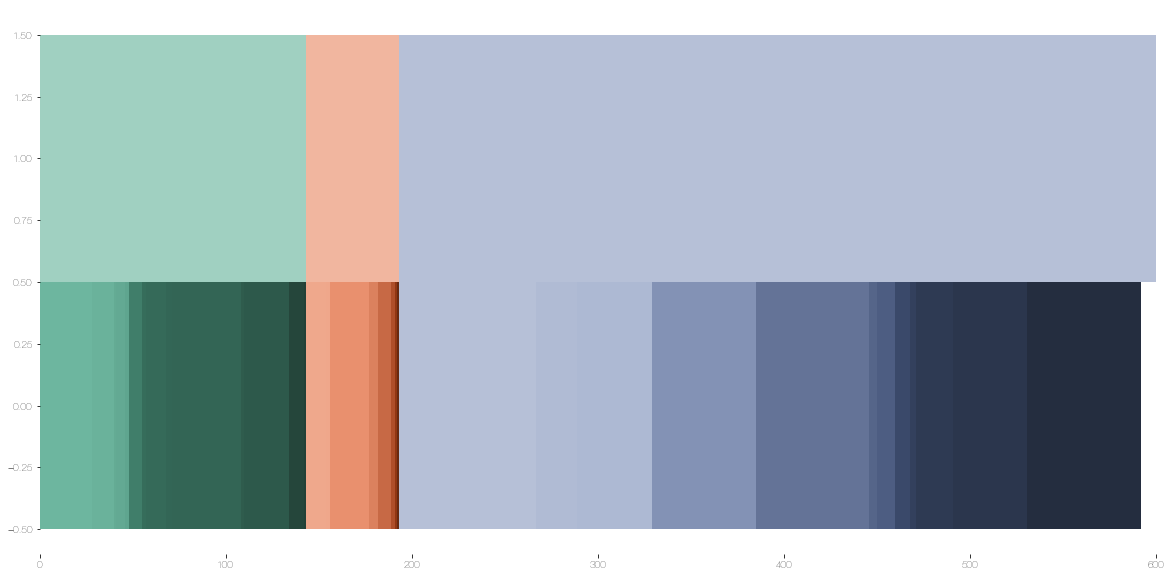

In [4]:
seq_path='/Users/evogytis/Documents/00_finished/space-time/Data/Makona_1610_genomes_2016-06-23.fasta'
all_seq={}

for line in open(seq_path,'r'): ## load sequences
    l=line.strip('\n')
    if '>' in l:
        name=l[1:]
    else:
        all_seq[name]=l
        
print len(set([s.split('|')[3] for s in all_seq]))
print len(set([s.split('|')[4] for s in all_seq]))

invalid = lambda seq:len(seq)-sum([seq.count(x) for x in ['C','T','G','A']]) ## anon function for counting non-ACTG nt
remove=[name for name in all_seq if invalid(all_seq[name])/float(len(all_seq[name]))>0.01] ## anything that's more than 1% not ACTG is marked for removal
remove+=[name for name in all_seq if '?' in name.split('|')[3:5] or '' in name.split('|')[3:5]] ## anything without known completely precise location is marked for removal

for key in set(remove): ## remove keys
    all_seq.pop(key)

print 'Remaining seqs: %s'%(len(all_seq))

subsample=set(all_seq).difference(set(np.random.choice(all_seq.keys(),size=600,replace=False))) ## pick 600 random taxa from what's left

for key in subsample: ## remove keys for things that were not picked
    all_seq.pop(key)

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 1,wspace=0.01) ## setup figure
ax = plt.subplot(gs[0])

cumulativeLoc=0
cumulativeCountry=0
storeCountry=''
for loc in sorted(locations,key=lambda x:(location_to_country[x],normalized_coords[x])):
    loc_count=[s.split('|')[4] for s in all_seq.keys()].count(loc)#/float(len(all_seq))
    country=location_to_country[loc]
    c=colours[loc]
    if country!=storeCountry:
        country_count=[s.split('|')[3] for s in all_seq.keys()].count(country)#/float(len(all_seq))
        ax.barh(1,country_count,left=cumulativeCountry,facecolor=c,height=1)
        cumulativeCountry+=country_count
        
    ax.barh(0,loc_count,left=cumulativeLoc,facecolor=c,height=1)
    
    cumulativeLoc+=loc_count
    storeCountry=country
    
loc_count=[s.split('|')[4] for s in all_seq.keys()].count('?')
country_count=[s.split('|')[3] for s in all_seq.keys()].count('?')
ax.barh(1,country_count,left=cumulativeCountry,facecolor='grey',height=1)
ax.barh(0,loc_count,left=cumulativeLoc,facecolor='grey',height=1)
    
[ax.spines[edge].set_visible(False) for edge in ['bottom','top','left','right']] ## make axes invisible
plt.show()

In [3]:
# mask=np.random.choice(all_seq.keys(),size=60,replace=False)
# mask_targets=open('/Users/evogytis/Documents/genomic-horizon/data/masked_set.txt','w')

# for strain in mask:
#     mask_targets.write('%s\n'%(strain))

# mask_targets.close()

mask=[]
for line in open('/Users/evogytis/Documents/genomic-horizon/data/masked_set.txt','r'):
    l=line.strip('\n')
    mask.append(l)
    
subset=[]
for line in open('/Users/evogytis/Documents/genomic-horizon/data/alignments/Makona_600_gp.fasta','r'):
    if '>' in line:
        subset.append(line.strip('\n')[1:])

print 'Done!'

Done!


In [6]:
# ### GP only
# alignment=open('/Users/evogytis/Documents/genomic-horizon/data/alignments/Makona_600_gp.fasta','w')

# for strain in all_seq:
#     ## 6051 : 8082
#     alignment.write('>%s\n%s\n'%(strain,all_seq[strain][6051:8082]))
# alignment.close()

# ### Whole genome
# alignment=open('/Users/evogytis/Documents/genomic-horizon/data/alignments/Makona_600_genomes.fasta','w')
# for strain in all_seq:
#     alignment.write('>%s\n%s\n'%(strain,all_seq[strain]))
# alignment.close()

# print 'Done!'

In [1]:
%%bash

rootdir=/Users/evogytis/Downloads/genomic-horizon/ ## base path where runs sit
subfolder=run* ## subfolder name where independent runs sit

rm -r $rootdir/combined ## delete combined directory if it exists
mkdir $rootdir/combined ## create empty directory for combined files

completeness=(Makona_600_genome.GLM.trees Makona_600_gp.GLM.trees) ## tree file
burnin=50000000 ## burnin
# burnin=1600

for class in ${completeness[*]} ## iterate over genomes, GPs and nothing
do
    for run in $rootdir$subfolder/$class ## iterate through log files
    do
        log=${run/.trees/.log}
        cut -f -1-5 $log>${run/.trees/.sub.log} ## subset columns for easier inspection
    done

    trees=$(ls -d $rootdir/$subfolder/$class) ## fetch all trees
    logs=$(ls -d $rootdir/$subfolder/${class/.trees/.log}) ## fetch all log files
#     logs=$(ls -d $rootdir/$subfolder/${class/.trees/.sub.log}) ## fetch all subsetted log files

    combined_trees=${class/.trees/.combined.trees} ## combine tree files
    combined_logs=${class/.trees/.combined.log} ## combine actual log files
#     combined_logs=${class/.trees/.combined.sub.log} ## combine subsetted log files
    
    cd $rootdir/combined; LogCombiner -burnin $burnin -trees $trees $combined_trees ## combine trees into one file post burnin
    cd $rootdir/combined; LogCombiner -burnin $burnin $logs $combined_logs ## combine logs into one file post burnin 

done;
echo Done!


               LogCombiner v1.8.2, 2002-2015
                    MCMC Output Combiner
                             by
           Andrew Rambaut and Alexei J. Drummond

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

               Department of Computer Science
                   University of Auckland
                  alexei@cs.auckland.ac.nz


Creating combined tree file: 'Makona_600_genome.GLM.combined.trees'


Combining file: '/Users/evogytis/Downloads/genomic-horizon//run0/Makona_600_genome.GLM.trees' removing burnin: 50000000
Combining file: '/Users/evogytis/Downloads/genomic-horizon//run1/Makona_600_genome.GLM.trees' removing burnin: 50000000
Combining file: '/Users/evogytis/Downloads/genomic-horizon//run2/Makona_600_genome.GLM.trees' removing burnin: 50000000
Finished.

               LogCombiner v1.8.2, 2002-2015
                    MCMC Output Combiner
                             by
         

rm: /Users/evogytis/Downloads/genomic-horizon//combined: No such file or directory


In [9]:
%%bash

## this cell subsampled GP trees (1/4), since there's too many for TreeAnnotator to handle

rootdir=/Users/evogytis/Downloads/genomic-horizon/combined ## base path where runs sit

trees=Makona_600_gp.GLM.combined.trees
subsampled_trees=${trees/.combined.trees/.combined.subsampled.trees}
logs=Makona_600_gp.GLM.combined.log
subsampled_logs=${logs/.combined.log/.combined.subsampled.log}

cd $rootdir; LogCombiner -resample 200000 -trees $trees $subsampled_trees ## combine trees into one file post burnin
cd $rootdir; LogCombiner -resample 200000 $logs $subsampled_logs ## combine logs into one file post burnin 

echo Done!


               LogCombiner v1.8.2, 2002-2015
                    MCMC Output Combiner
                             by
           Andrew Rambaut and Alexei J. Drummond

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

               Department of Computer Science
                   University of Auckland
                  alexei@cs.auckland.ac.nz


Creating combined tree file: 'Makona_600_gp.GLM.combined.subsampled.trees'


Combining file: 'Makona_600_gp.GLM.combined.trees' without removing burnin, resampling with frequency: 200000
Finished.

               LogCombiner v1.8.2, 2002-2015
                    MCMC Output Combiner
                             by
           Andrew Rambaut and Alexei J. Drummond

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

               Department of Computer Science
                   Univers

In [10]:
%%bash

## produce MCC tree from subsampled GP trees

rootdir=/Users/evogytis/Downloads/genomic-horizon/combined ## base path where runs sit

subsampled_trees=Makona_600_gp.GLM.combined.subsampled.trees
mcc_trees=${subsampled_trees/.combined.subsampled.trees/.mcc.tree} ## mcc tree file name

cd $rootdir; treeannotator -heights ca $subsampled_trees $mcc_trees ## make MCC tree from combined subsampled posterior

echo Done!

Please cite: Heled and Bouckaert: Looking for trees in the forest:
summary tree from posterior samples. BMC Evolutionary Biology 2013 13:221.
Done!


JRI not available. Using Java bivariate attributes

              TreeAnnotator v1.8.2, 2002-2015
                    MCMC Output analysis
                             by
           Andrew Rambaut and Alexei J. Drummond

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

               Department of Computer Science
                   University of Auckland
                  alexei@cs.auckland.ac.nz


Reading trees (bar assumes 10,000 trees)...
0              25             50             75            100
|--------------|--------------|--------------|--------------|
********************************************************************

Total trees read: 11397
Total unique clades: 2404430

Finding maximum credibility tree...
Analyzing 11397 trees...
0              25             50             75            100
|--------------|--------------|--------------|--------------|
*************************************

In [ ]:
%%bash

## produce MCC tree for genomes

rootdir=/Users/evogytis/Downloads/genomic-horizon/combined ## base path where runs sit

trees=Makona_600_genome.GLM.combined.trees
mcc_trees=${class/.combined.trees/.mcc.tree} ## mcc tree file name

cd $rootdir; treeannotator -heights ca $trees $mcc_trees ## make MCC tree from combined posterior

echo Done!

In [ ]:
# print len(set([s.split('|')[3] for s in all_seq]))
# print len(set([s.split('|')[4] for s in all_seq]))

template=open('/Users/evogytis/Documents/genomic-horizon/data/xml/Makona_GLM_template_genome.xml','r')
XML=open('/Users/evogytis/Documents/genomic-horizon/data/xml/Makona_GLM_600_genome.xml','w')
fname='/Users/evogytis/Documents/00_finished/space-time/Data/Makona_1610_genomes_2016-06-23.fasta'

# template=open('/Users/evogytis/Documents/genomic-horizon/data/xml/Makona_GLM_template_gp.xml','r')
# XML=open('/Users/evogytis/Documents/genomic-horizon/data/xml/Makona_GLM_600_gp.xml','w')
# fname='/Users/evogytis/Documents/genomic-horizon/data/alignments/Makona_600_gp.fasta'

seqs={}
for line in open(fname,'r'):
    l=line.strip('\n')
    if '>' in l:
        name=l[1:]
        if name in subset:
            seqs[name]=''
    elif name in subset:
        seqs[name]+=l.replace('U','T')
    
chunkSize=2000

for line in template:
    l=line.strip('\n')
    
    if '</taxa>' in l:
        for taxon in seqs:
            species,strain,accession,country,location,date=taxon.split('|')
            if location=='':
                location='?'
            if country=='':
                country='?'
            date=bt.decimalDate(date,variable=True)
            
            if taxon not in mask:
                XML.write('\t\t<taxon id="%s">\n\t\t\t<date value="%.6f" direction="forwards" units="years"/>\n\t\t\t<attr name="country">\n\t\t\t\t%s\n\t\t\t</attr>\n\t\t\t<attr name="location">\n\t\t\t\t%s\n\t\t\t</attr>\n\t\t</taxon>\n'%(taxon,date,country,location))
            else:
                XML.write('\t\t<taxon id="%s">\n\t\t\t<date value="2013.91506849" direction="forwards" units="years" precision="2.0"/>\n\t\t\t<attr name="country">\n\t\t\t\t?\n\t\t\t</attr>\n\t\t\t<attr name="location">\n\t\t\t\t?\n\t\t\t</attr>\n\t\t</taxon>\n'%(taxon))
            
    cerberus=re.search('</alignment>',l)
    if cerberus:
        for taxon in seqs:
            sequence=seqs[taxon]
            sequence='\n\t\t\t'.join(sequence[i:i+chunkSize] for i in range(0,len(sequence)+chunkSize,chunkSize))
        
            XML.write('\t\t<sequence>\n\t\t\t<taxon idref="%s"/>\n\t\t\t%s\n\t\t</sequence>\n'%(taxon,sequence)) ## insert sequences
    
    cerberus=re.search('</treeModel>',line)
    if cerberus:
        for taxon in mask:
            XML.write('\t\t<leafHeight taxon="%s">\n\t\t\t<parameter id="age(%s)"/>\n\t\t</leafHeight>\n'%(taxon,taxon)) ## insert parameters
    
    cerberus=re.search('</operators>',line)
    if cerberus:
        for taxon in mask:
            XML.write('\t\t<uniformOperator weight="1">\n\t\t\t<parameter idref="age(%s)"/>\n\t\t</uniformOperator>\n'%(taxon)) ## insert operators
    
    cerberus=re.search('</log>',line)
    if cerberus:
        for taxon in mask:
            XML.write('\t\t\t<parameter idref="age(%s)"/>\n'%(taxon)) ## insert log elements
    
    XML.write(line)
    
XML.close()

genome 4330
gp 38855
gp


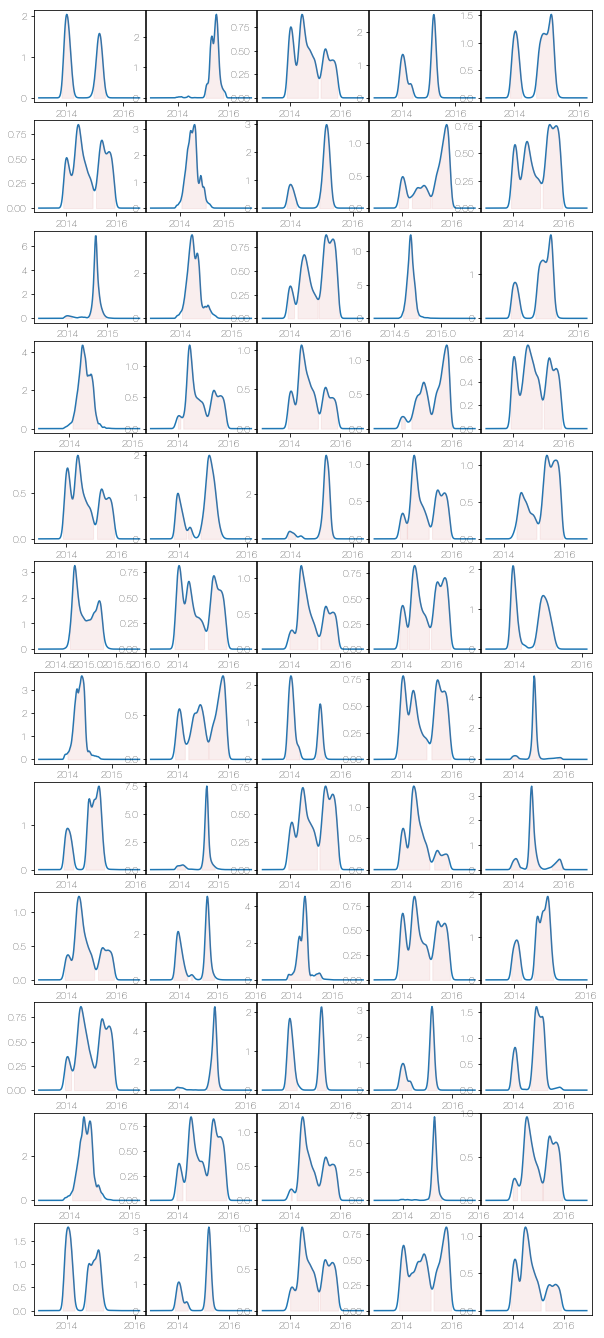

genome


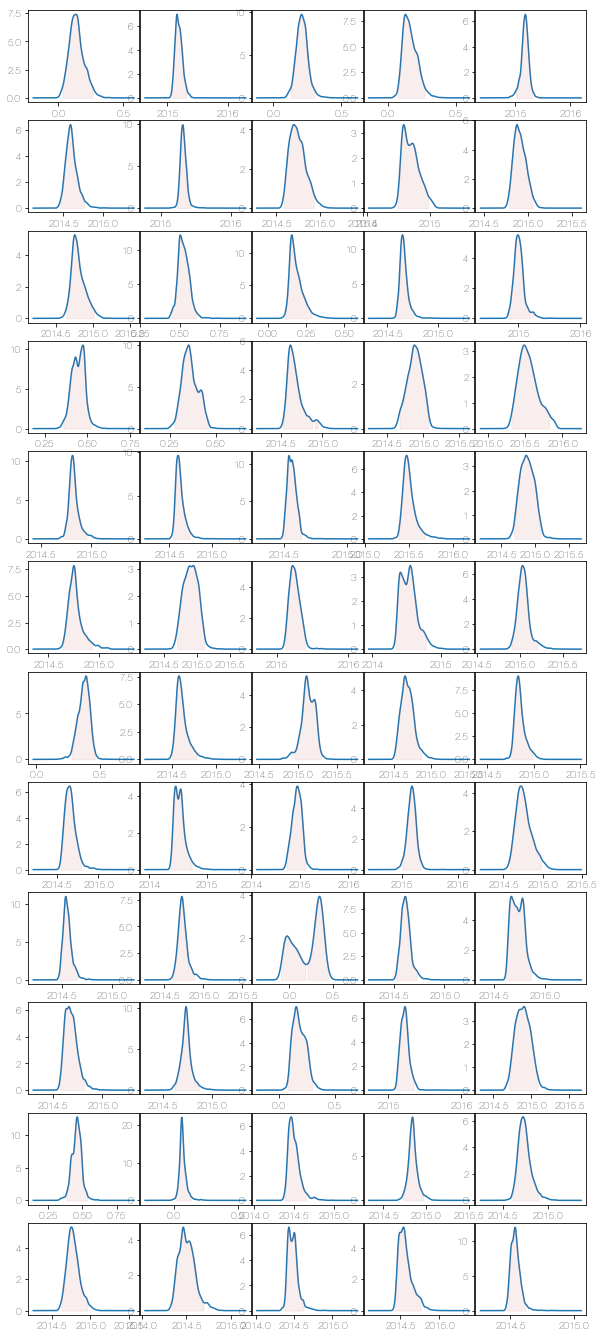

In [3]:
def hdr(samples,alpha=0.05,yN=1000,xN=1000):
    """
    This function crappily integrates posterior samples via grid search.
    """
    kde=gaussian_kde(samples)
    D=max(samples)-min(samples) ## total range
    x_grid=np.linspace(min(samples)-0.5*D,max(samples)+0.5*D,xN) ## integration grid along x
    y_grid=kde.evaluate(x_grid) ## y values
    
    bestScore=1.0
    bestPair=()
    for y in np.linspace(0.0,1.0,yN): ## draw horizontal lines to check for intersects
        start=[]
        end=[]
        for q in range(len(y_grid)-1):
            if y_grid[q] <= y < y_grid[q+1]: ## intersect curve going upwards
                start.append(x_grid[q])
            elif y_grid[q+1] < y <= y_grid[q]: ## intersect curve going downwards
                if len(start) < len(end): ## curve started going down
                    start.append(xmin)
                end.append(x_grid[q])
        
        density=0.0
        if len(start)>0 and len(end)>0:
            pairs=zip(start,end) ## get pairs of x coordinates that define a peak
            for pair in pairs:
                density+=kde.integrate_box_1d(*pair) ## cumulative density captured by peak
            if density>0.0 and abs(1-alpha-density)<abs(1.0-alpha-bestScore): ## found a better pair
                bestScore=density
                bestPair=pairs
                
    return bestPair,bestScore
    
# log_paths=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_genome.GLM.log'%(i) for i in range(5)]
# log_paths+=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_gp.GLM.log'%(i) for i in range(5)]
log_paths=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_genome.GLM.log'%(i) for i in range(3)]
log_paths+=['/Users/evogytis/Downloads/genomic-horizon/run%d/Makona_600_gp.GLM.log'%(i) for i in range(3,10)]

data={}
for log_path in log_paths:
    if 'genome' in log_path:
        log='genome'
        burnin=50000000
    else:
        log='gp'
        burnin=50000000
    
    for line in open(log_path,'r'):
        if '#' not in line:
            l=line.strip('\n').split('\t')
            if l[0]=='state':
                header=l
                if data.has_key(log)==False:
                    data[log]={x:[] for i,x in enumerate(header)}
            elif len(l)==len(header) and int(l[0])>burnin:
                for i,x in enumerate(l):
                    if 'age(' in header[i]:
                        data[log][header[i]].append(2016.0-float(x))
                    elif 'ucld' in header[i] or 'meanRate' in header[i]:
                        data[log][header[i]].append(float(x))

for x in data.keys():
    print x,len(data[x]['ucld.mean'])

for gene in ['gp','genome']:
    print gene
    
    fig = plt.figure(figsize=(10, 24))
    gs = gridspec.GridSpec(12, 5,wspace=0.01) ## setup figure with two columns
    out=open('/Users/evogytis/Documents/genomic-horizon/data/plot/%s_ageHPDS.txt'%(gene),'w')
    out.write('tip\t95\% HPDs\tintegral\n')
    k=0
    for key in data[gene].keys():
        if 'age(' in key:
            sam=data[gene][key]
            D=max(sam)-min(sam)
            kde=gaussian_kde(sam)
            x_grid=np.linspace(min(sam)-0.5*D,max(sam)+0.5*D,200)
            y_grid=kde.evaluate(x_grid)

            hpds,score=hdr(sam,alpha=0.05,yN=1000,xN=1000)
            formatted_intervals=','.join(['-'.join(map(str,interval)) for interval in hpds])
            out.write('%s\t%s\t%s\n'%(key[4:-1],formatted_intervals,score))
#             print k,k/12,k%12
            ax = plt.subplot(gs[k%12,k/12])
            ax.plot(x_grid,y_grid)
            for interval in hpds:
                xs=np.linspace(*interval,num=100)
                ax.fill_between(xs,kde.evaluate(xs),zorder=10,color='indianred',alpha=0.1)
            k+=1
            
    plt.show()
    out.close()

In [ ]:
%%bash

trees=/Users/evogytis/Downloads/genomic-horizon/combined/*combined*trees

for tree in $trees
    do
    python /Users/evogytis/Documents/genomic-horizon/scripts/samogitia.py -t $tree -a ancestry -o ${tree/.trees/.ancestry.log}
done;